# Análise da Rentabilidade de Fundos

### Inicializações

In [1]:
import pandas as pd
from datetime import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sn

encoding='latin_1'
thousands = ','
decimal = '.'
to_date = lambda d: datetime.strptime(d, '%d-%m-%Y').date()
transacoes_csv = 'transacoes.csv'
cotacoes_xls = 'historico_cotacoes.xlsx'

In [2]:
#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')['USD2EUR']
exchange_rates.head()

Date
2022-12-04    0.94860
2022-12-03    0.94902
2022-12-02    0.94908
2022-12-01    0.94991
2022-11-30    0.95935
Name: USD2EUR, dtype: float64

### Obter informação de cotações

In [3]:
#Read XLS
dict_df = pd.read_excel(cotacoes_xls,sheet_name=None)

# Parse the date and set it as index
for key in dict_df.keys():
    dict_df[key]['Date'] = dict_df[key].apply(lambda x: pd.to_datetime(x['Date'], infer_datetime_format = True).date(), axis=1)
    dict_df[key].set_index('Date',drop=True, inplace=True)

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_cotacoes = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False).fillna(method='bfill').fillna(method='pad')

df_cotacoes.head()


,LU0094557526,LU0171309270,LU0248173006,PTSQUGHM0007,LU0384381660,LU0823417141,LU1769942746,LU2210151697,IE00BD3B6K23,LU0108459040,...,LU0269905138,LU0524465977,LU0815616999,LU1670707956,IE0002167009,LU0248185513,LU0197230542,LU0122613903,LU1883314244,LU1897414303
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-05,45.26,55.44,39.50,10.75,66.44,421.09,324.44,10.71,106.81,810.16,...,16.05,238.75,9.38,10.99,15.30,187.06,75.24,8.42,137.18,18.06
2022-12-02,45.26,55.44,38.88,10.75,66.44,421.09,324.44,10.71,106.81,810.16,...,15.83,238.75,9.38,10.94,15.30,187.69,75.24,8.42,137.18,17.98
2022-12-01,45.27,55.62,39.20,10.74,67.82,419.62,328.66,10.69,106.74,797.62,...,16.01,239.20,9.41,10.91,15.40,191.18,75.72,8.44,137.08,17.96
2022-11-30,45.33,55.03,38.91,10.74,65.97,423.36,320.05,10.70,106.65,794.81,...,15.87,237.37,9.40,10.81,15.29,187.57,76.42,8.43,136.23,17.68
2022-11-29,44.51,54.94,38.34,10.74,65.20,408.76,322.43,10.74,106.84,766.31,...,15.61,235.43,9.20,10.73,14.49,188.18,75.39,8.36,135.93,17.26


In [4]:
df_cotacoes

,LU0094557526,LU0171309270,LU0248173006,PTSQUGHM0007,LU0384381660,LU0823417141,LU1769942746,LU2210151697,IE00BD3B6K23,LU0108459040,...,LU0269905138,LU0524465977,LU0815616999,LU1670707956,IE0002167009,LU0248185513,LU0197230542,LU0122613903,LU1883314244,LU1897414303
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-05,45.26,55.44,39.50,10.75,66.44,421.09,324.44,10.71,106.81,810.16,...,16.05,238.75,9.38,10.99,15.30,187.06,75.24,8.42,137.18,18.06
2022-12-02,45.26,55.44,38.88,10.75,66.44,421.09,324.44,10.71,106.81,810.16,...,15.83,238.75,9.38,10.94,15.30,187.69,75.24,8.42,137.18,17.98
2022-12-01,45.27,55.62,39.20,10.74,67.82,419.62,328.66,10.69,106.74,797.62,...,16.01,239.20,9.41,10.91,15.40,191.18,75.72,8.44,137.08,17.96
2022-11-30,45.33,55.03,38.91,10.74,65.97,423.36,320.05,10.70,106.65,794.81,...,15.87,237.37,9.40,10.81,15.29,187.57,76.42,8.43,136.23,17.68
2022-11-29,44.51,54.94,38.34,10.74,65.20,408.76,322.43,10.74,106.84,766.31,...,15.61,235.43,9.20,10.73,14.49,188.18,75.39,8.36,135.93,17.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-07,46.63,49.62,46.39,10.17,69.89,377.90,297.16,9.80,105.39,823.21,...,21.65,216.13,8.76,11.44,25.26,200.19,74.53,27.23,137.43,17.68
2021-07-06,46.27,49.19,46.16,10.17,69.89,377.90,297.16,9.80,105.39,823.21,...,21.65,216.13,8.76,11.44,25.26,200.19,74.53,27.23,137.43,17.68
2021-07-05,46.28,49.40,46.08,10.17,69.89,377.90,297.16,9.80,105.39,823.21,...,21.65,216.13,8.76,11.44,25.26,200.19,74.53,27.23,137.43,17.68


### Obter informação de transações

In [5]:
converters={'Data de subscricao': to_date}
df_transacoes = pd.read_csv(transacoes_csv ,sep=',',encoding=encoding,thousands=thousands, decimal=decimal, converters=converters, dtype={'Cotacao de Subscricao':float,'Quantidade':float})
df_transacoes['Data de resgate'] = df_transacoes['Data de resgate'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').date() if pd.notnull(x) else x)

# Criar Dataframe de Portofolio Actual
df_portofolio = df_transacoes[pd.isnull(df_transacoes['Data de resgate'])].drop(columns=['Data de resgate','Cotacao de resgate']).copy()

i = 0
while df_cotacoes.index[i] > exchange_rates.index[0]:
    exchange_rates[df_cotacoes.index[i]] = exchange_rates[0]
    i += 1
    
last_date = min(df_cotacoes.index[0],exchange_rates.index[0])
# Get the exchange rate for the last date of the historical quotes
usd2eur = exchange_rates.loc[last_date]

df_portofolio['Data da cotacao'] = df_cotacoes.index[0]
df_portofolio['cotacao actual'] = df_portofolio.apply(lambda x: df_cotacoes[x['Code']][0] * (usd2eur if x['Moeda'] == 'USD' else 1), axis=1)
df_portofolio['Dias'] = (df_portofolio['Data da cotacao']-df_portofolio['Data de subscricao']).apply(lambda x: x.days)

# Criar Dataframe com o Historico
df_historico = df_transacoes[pd.notnull(df_transacoes['Data de resgate'])].copy()
df_historico['Dias'] = (df_historico['Data de resgate']-df_historico['Data de subscricao']).apply(lambda x: x.days)

In [6]:
df_historico['Quantidade']

4        5.340
8       71.700
14     207.684
19      17.264
20       8.100
        ...   
294     10.592
295      7.431
296     92.030
297     11.850
298     28.550
Name: Quantidade, Length: 248, dtype: float64

### Cálculo Rentabilidade do Histórico

In [7]:
df_historico['Rentabilidade anual %'] = df_historico.apply(lambda x: 100*(math.pow(x['Cotacao de resgate']/x['Cotacao de Subscricao'],
                                                        float(365.0/x['Dias']))-1), axis=1)
df_historico['Rentabilidade Absoluta'] = df_historico['Cotacao de resgate']*100/df_historico['Cotacao de Subscricao']-100

df_historico['Valor Actual'] = df_historico['Quantidade']*df_historico['Cotacao de resgate']


print("Rentabilidade Absoluta", sum(df_historico['Quantidade']*df_historico['Cotacao de resgate'])*100/sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao'])-100)

df_historico['Ganho Absoluto'] = df_historico['Quantidade']*(df_historico['Cotacao de resgate']-df_historico['Cotacao de Subscricao'])
print("Ganho Absoluto", sum(df_historico['Ganho Absoluto']),'em', sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao']))

dias_medio = (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']*df_historico['Dias']).sum() / (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']).sum()
print("Rentabilidade Média Anual", 100*(math.pow(df_historico['Ganho Absoluto'].sum()/sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao'])+1, float(365.0/dias_medio))-1))


Rentabilidade Absoluta 4.749267024880183
Ganho Absoluto 18547.294092791122 em 390529.6121617524
Rentabilidade Média Anual 7.303816585992151


In [8]:
df_historico.sort_values(by=['Data de resgate'],ascending=False)

,Code,Nome,Quantidade,Data de subscricao,Cotacao de Subscricao,Moeda,Data de resgate,Cotacao de resgate,Dias,Rentabilidade anual %,Rentabilidade Absoluta,Valor Actual,Ganho Absoluto
4,LU0248185513,Schroder US Large Cap B Accum,5.340,2022-11-14,188.947900,EUR,2022-11-28,187.308400,14,-20.324562,-0.867700,1000.226856,-8.754930
64,LU2210151697,FF Abs Ret Gb Eq,102.900,2022-09-05,10.435254,USD,2022-11-28,10.391448,84,-1.811308,-0.419787,1069.280000,-4.507618
89,LU0248173006,SIC Asia B accum EUR,27.260,2022-06-27,42.688100,EUR,2022-11-28,36.996600,154,-28.762568,-13.332755,1008.527316,-155.150290
25,LU0108459040,Candriam Biotech C Cap USD,1.430,2022-09-12,753.835962,USD,2022-11-28,747.748252,77,-3.770676,-0.807564,1069.280000,-8.705426
90,LU0248173006,SIC Asia B accum EUR,26.800,2022-11-08,37.335400,EUR,2022-11-28,36.996600,20,-15.326336,-0.907450,991.508880,-9.079840
...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,LU0260085492,Jupiter Europ Grw,13.920,2017-07-06,31.280000,EUR,2019-06-06,35.920000,700,7.478599,14.833760,500.006400,64.588800
216,LU0117884675,JPM Europ Dyn Tech,36.101,2016-01-29,9.820000,EUR,2019-06-06,13.850000,1224,10.798292,41.038697,499.998850,145.487030
201,LU1321847805,BSF Emer Mkt Strat,15.560,2019-03-08,163.530000,EUR,2019-06-06,160.690000,90,-6.858558,-1.736684,2500.336400,-44.190400
158,LU1548497772,A Artific Intellig,8.305,2017-07-07,104.060000,EUR,2019-06-05,120.411000,698,7.930468,15.713050,1000.013355,135.795055


### Cálculo Rentabilidade do Portfólio

In [9]:
df_portofolio['Rentabilidade anual %'] = df_portofolio.apply(lambda x: 100*(math.pow(x['cotacao actual']/x['Cotacao de Subscricao'],
                                                        float(365.0/x['Dias']))-1), axis=1)

df_portofolio['Rentabilidade Absoluta'] = df_portofolio['cotacao actual']*100/df_portofolio['Cotacao de Subscricao']-100
df_portofolio['Valor Actual'] = df_portofolio['Quantidade']*df_portofolio['cotacao actual']
print("Rentabilidade Absoluta", sum(df_portofolio['Valor Actual'])*100/sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao'])-100)

df_portofolio['Ganho Absoluto'] = df_portofolio['Quantidade']*(df_portofolio['cotacao actual']-df_portofolio['Cotacao de Subscricao'])
print("Ganho Absoluto", sum(df_portofolio['Ganho Absoluto']),'em', sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']),'=', sum(df_portofolio['Valor Actual']))

dias_medio = (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']*df_portofolio['Dias']).sum() / (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']).sum()
print("Rentabilidade Média Anual", 100*(math.pow(df_portofolio['Ganho Absoluto'].sum()/sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao'])+1, 
                                                 float(365.0/dias_medio))-1))


Rentabilidade Absoluta 1.7566494391464431
Ganho Absoluto 2211.229758827591 em 125877.6913339084 = 128088.921092736
Rentabilidade Média Anual 10.794127886224425


In [10]:
df_portofolio.groupby(by=["Code","Nome"]).sum()[['Quantidade','Valor Actual','Ganho Absoluto']]

,,Quantidade,Valor Actual,Ganho Absoluto
Code,Nome,,,
IE0002167009,JH Glob Tech and Innov A2,134.04800,2050.934400,50.938240
IE00BD3B6K23,MAN Emerg Debt Total R D USD,20.00000,2026.399320,-135.199384
IE00BLP5S460,Jupiter Glb Abs Rt EUR,1474.38300,2005.160880,5.160341
LU0094557526,MFS European Research A1 EUR,152.79100,6915.320660,324.866040
LU0108459040,Candriam Biotech C Cap USD,7.83800,6023.642328,296.297754
LU0122613903,T Eastern Europe,32.19600,271.090320,-728.917440
LU0171309270,BGF Healthscience E2 EUR,103.70000,5749.128000,8.017200
LU0197230542,Fidelity India Focus A,26.76000,2013.422400,13.112400
LU0213962813,HSBC Turkey Equity Eur,138.58800,5179.033560,879.549226


In [11]:
df_portofolio[df_portofolio['Code']=='LU0171310955']

,Code,Nome,Quantidade,Data de subscricao,Cotacao de Subscricao,Moeda,Data da cotacao,cotacao actual,Dias,Rentabilidade anual %,Rentabilidade Absoluta,Valor Actual,Ganho Absoluto


<AxesSubplot:xlabel='Date'>

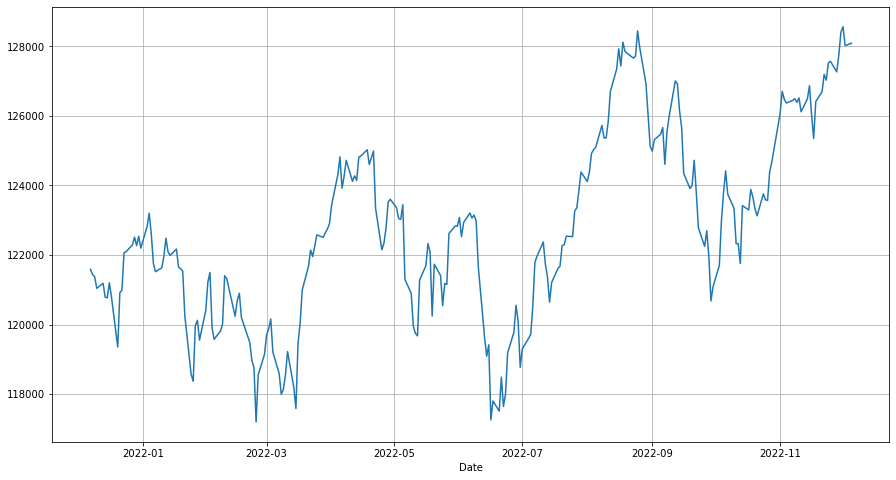

In [12]:
#Get the Portofolio
size=260
portfolio_csv = 'portofolio.csv'
df_meta = pd.read_csv(portfolio_csv ,sep=';').set_index('Code')
df_global = df_cotacoes[:size].apply(lambda x: sum(df_meta['Quantidade'][k]*v*(exchange_rates[x.name] if df_meta['Moeda'][k] == 'USD' else 1) for k,v in x.items()),axis=1)        
df_global[:].plot(figsize=(15,8),grid=True)

In [13]:
start =31
stop = 0
df_global_grow = (df_global / df_global.shift(-1)).dropna()
growth = (df_global.iloc[stop]/df_global.iloc[start]-1)
growth_abs = df_global.iloc[stop] - df_global.iloc[start]
std = df_global_grow.std()
'Growth ABS = {:.2f}, Growth = {:.2%}, STD = {:.6f}, Racio = {:.3f}'.format(growth_abs, growth,std,growth/std)

'Growth ABS = 4962.36, Growth = 4.03%, STD = 0.005696, Racio = 7.076'

# SP 500 Comparision

In [14]:
# https://www.spglobal.com/spdji/en/indices/equity/sp-500/#overview
df_sp500 = pd.read_excel('PerformanceGraphExport.xls', sheet_name="Performance Graph", header=None, names=['Date','Value'], usecols="A:B", skiprows=7).dropna()
ds_sp500 = df_sp500['Value']
ds_sp500.index = df_sp500['Date'].apply(lambda x: x.date())
ds_sp500 = ds_sp500.reindex(pd.date_range(ds_sp500.index.min(),ds_sp500.index.max())).interpolate()
ds_sp500

2012-11-30    1587.490000
2012-12-01    1582.346667
2012-12-02    1577.203333
2012-12-03    1572.060000
2012-12-04    1567.600000
                 ...     
2022-11-28    6743.380000
2022-11-29    6759.890000
2022-11-30    7011.560000
2022-12-01    6879.680000
2022-12-02    6880.540000
Freq: D, Name: Value, Length: 3655, dtype: float64

In [15]:
df_sp500_hist = df_historico[['Dias']].copy()
df_sp500_hist['Cost'] = df_historico.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao'],axis=1)
df_sp500_hist['Quantidade'] = df_historico.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao']/ds_sp500[pd.to_datetime(x['Data de subscricao'])],axis=1)
df_sp500_hist['Net'] = df_sp500_hist['Quantidade']*df_historico.apply(lambda x: (ds_sp500[pd.to_datetime(x['Data de resgate'])]-ds_sp500[pd.to_datetime(x['Data de subscricao'])]),axis=1)
dias_medio = (df_sp500_hist['Cost']*df_sp500_hist['Dias']).sum() / df_sp500_hist['Cost'].sum()
print("SP500 Histórico: Custo={}, Ganho={}".format(df_sp500_hist['Cost'].sum(),df_sp500_hist['Net'].sum()))
print("Rentabilidade SP500 Histórico", 100*(math.pow(df_sp500_hist['Net'].sum()/sum(df_sp500_hist['Cost'])+1, 
                                                 float(365.0/dias_medio))-1))


SP500 Histórico: Custo=390529.61216175207, Ganho=42892.34180626039
Rentabilidade SP500 Histórico 17.154327863546758


In [16]:
df_sp500_portf = df_portofolio[['Code']].copy()
df_portf_tmp = df_portofolio[df_portofolio['Data de subscricao'].apply(lambda x: pd.to_datetime(x)) <= ds_sp500.index.max()]
df_sp500_portf['Days'] = df_portf_tmp.apply(lambda x: (dict_df[x['Code']].index.max() - x['Data de subscricao']).days, axis=1)
df_sp500_portf['Quantidade'] = df_portf_tmp.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao']/ds_sp500[pd.to_datetime(x['Data de subscricao'])],axis=1)
df_sp500_portf['Cost'] = df_portf_tmp.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao'],axis=1)
df_sp500_portf['Net'] = df_sp500_portf['Quantidade']*df_portf_tmp.apply(lambda x: (ds_sp500.loc[ds_sp500.index.max()]-ds_sp500[pd.to_datetime(x['Data de subscricao'])]),axis=1)
dias_medio = (df_sp500_portf['Cost']*df_sp500_portf['Days']).sum() / df_sp500_portf['Cost'].sum()
print("SP500 Portfolio: Custo={}, Ganho={}".format(df_sp500_portf['Cost'].sum(),df_sp500_portf['Net'].sum()))
print("Rentabilidade SP500 Portfolio at {}".format(ds_sp500.index.max()), 100*(math.pow(df_sp500_portf['Net'].sum()/sum(df_sp500_portf['Cost'])+1, 
                                                 float(365.0/dias_medio))-1))

SP500 Portfolio: Custo=125877.6913339084, Ganho=1063.6637667271114
Rentabilidade SP500 Portfolio at 2022-12-02 00:00:00 5.270814665906887


<AxesSubplot:>

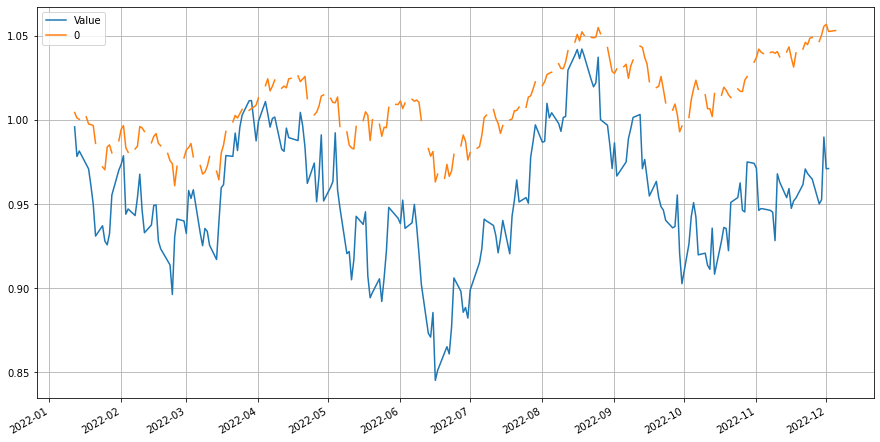

In [17]:
#Comparision of the current portfolio
n_days = 235
df = df_cotacoes[:n_days].apply(lambda x: sum(df_meta['Quantidade'][k]*v*(exchange_rates[x.name] if df_meta['Moeda'][k] == 'USD' else 1) for k,v in x.items()),axis=1).sort_index()
pd.concat([ds_sp500[df.index.min():].pct_change().cumsum()+1, df.pct_change().cumsum()+1],axis=1).plot(figsize=(15,8),grid=True)

<AxesSubplot:>

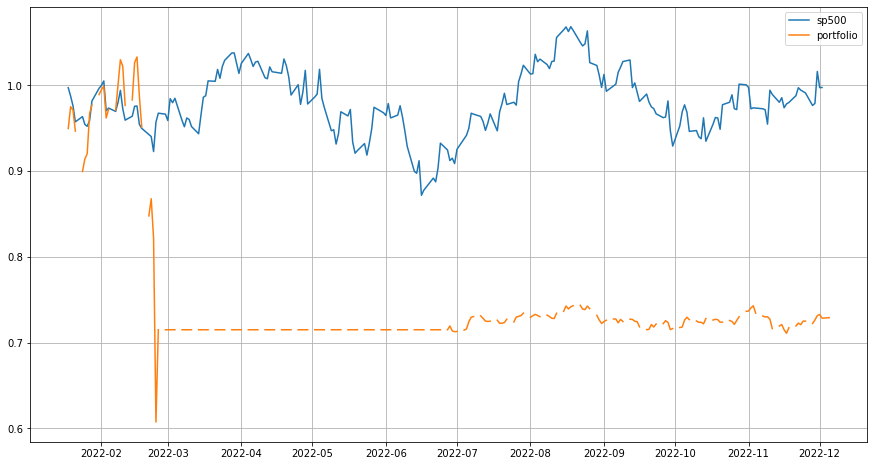

In [18]:
n_days = 230
df_t = df_transacoes[df_transacoes['Code'].isin(df_cotacoes.columns)].copy()
first_date = max(df_cotacoes.index[n_days],df_t['Data de subscricao'].min())
portf_perform = []
df_tmp = df_t[(df_t['Data de subscricao']<=first_date) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>first_date))]
last_val = df_tmp.apply(lambda x: x['Quantidade']*df_cotacoes[x['Code']][first_date] * (exchange_rates.loc[first_date] if x['Moeda'] == 'USD' else 1), axis=1).sum()
for i_date in df_cotacoes[:first_date].index.sort_values()[1:]:
    df_tmp = df_t[(df_t['Data de subscricao']<i_date) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>=i_date))]
    new_val = df_tmp.apply(lambda x: x['Quantidade']*df_cotacoes[x['Code']][i_date] * (exchange_rates.loc[i_date] if x['Moeda'] == 'USD' else 1), axis=1).sum()
    portf_perform.append(new_val/last_val-1.0)
    df_tmp = df_t[(df_t['Data de subscricao']<=i_date) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>i_date))]
    last_val = df_tmp.apply(lambda x: x['Quantidade']*df_cotacoes[x['Code']][i_date] * (exchange_rates.loc[i_date] if x['Moeda'] == 'USD' else 1), axis=1).sum()
portf_perform = pd.Series(data=portf_perform, index= df_cotacoes[:first_date].index.sort_values()[1:], name="portfolio")

sp500_perform = []
last_val = ds_sp500[pd.to_datetime(first_date)]
for i_date in ds_sp500[pd.to_datetime(first_date):].index[1:]:
    sp500_perform.append(ds_sp500[i_date]/last_val-1.0)
    last_val = ds_sp500[i_date]

sp500_perform = pd.Series(data=sp500_perform, index= [x.date() for x in ds_sp500[pd.to_datetime(first_date):].index[1:]], name="sp500")

pd.concat([sp500_perform.cumsum()+1, portf_perform.cumsum()+1],axis=1).plot(figsize=(15,8),grid=True)


In [19]:
n_days = 230
df_t = df_transacoes[df_transacoes['Code'].isin(df_cotacoes.columns)].copy()
first_date = max(df_cotacoes.index[n_days],df_t['Data de subscricao'].min())
portf_perform = []
df_tmp = df_t[(df_t['Data de subscricao']<=first_date) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>first_date))]
last_val = df_tmp.apply(lambda x: x['Quantidade']*df_cotacoes[x['Code']][first_date] * (exchange_rates.loc[first_date] if x['Moeda'] == 'USD' else 1), axis=1).sum()

In [20]:
df_cotacoes[:first_date].index.sort_values()

Index([2022-01-17, 2022-01-18, 2022-01-19, 2022-01-20, 2022-01-21, 2022-01-24,
       2022-01-25, 2022-01-26, 2022-01-27, 2022-01-28,
       ...
       2022-11-22, 2022-11-23, 2022-11-24, 2022-11-25, 2022-11-28, 2022-11-29,
       2022-11-30, 2022-12-01, 2022-12-02, 2022-12-05],
      dtype='object', name='Date', length=231)